# 프로젝트 목표 : Wafer test step 변경 시 상하단 test성 불량 검출

## &nbsp;세부 목표 : lot, wafer 번호, x y좌표, 실수형 test 데이터를 활용하여 불량 분류 수행
    1) 실수형 test 데이터 전처리
    2) wafer map 생성 및 이미지 전처리
    3) 모델 학습 및 평가

In [55]:
import numpy as np
import pyarrow as pa
import pandas as pd
import scipy as sp
import matplotlib
import seaborn as sns
import plotly as px
import sklearn as sk
import torch, torchvision, torchaudio
import matplotlib.pyplot as plt
root = "C:\\Users\\User\\project\\ai_intensive"

# 1) 실수형 데이터 전처리

## &nbsp;&nbsp; Data Set : 불량 유형별 wafer test data
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [kaggle data set] https://www.kaggle.com/datasets/sakshamshah/wafer-ann

### 데이터 전처리 과정
    1. csv 각 row / column 구분하여 dataframe 생성
    2. 결측치 확인
    3. 이상 문자열 변환
    4. 실수형 데이터 형변환
    5. 학습 규모에 맞게 row 추출
    6. 각 불량 type별 측정치 scailing
    7. 데이터 분포 시각화 및 상관관계 분석
    8. 학습 feature 선택
    9. 전처리 데이터 csv 저장

In [56]:
df=pd.read_csv(root + f"/dataset/training_1.csv", encoding='cp949')

In [57]:
df.head()

,,,,,,,,,,"lot;""wafer"";""x"";""y"";""ring"";""spot"";""trend"";""twospots"";""crescent"";""ring_pure"";""spot_pure"";""trend_pure"";""twospots_pure"";""crescent_pure"""
Lot_1;1;1;67;0,0332031730845769;6,48519201883132e-05;0,312294593060493;0,0390430665764935;0,00771987128577758;0,0325758284622229;6,54906689829159e-10;0,285687707722175;0,0395706499953045;-4,0.000843
Lot_1;1;1;68;0,0328173889580282;-4,66246954348572e-06;0,288024790081015;0,0405631417212302;0,00263633379698886;0,0327267641746118;8,76695244240241e-10;0,281496623060313;0,0404069156343969;-5,0.000076
Lot_1;1;1;69;0,0333211682053133;2,47580311665707e-05;0,261521426704379;0,0416022202035901;-0,000592417759195467;0,0328494417424522;1,16997736424868e-09;0,277305538398452;0,0411276544095511;-5,0.000290
Lot_1;1;1;70;0,0327066816529719;-1,41399015151066e-05;0,290740671081819;0,0408216721611609;0,00851014186519874;0,0329476626926438;1,55655995468072e-09;0,27311445373659;0,0417415065091455;-5,0.000561
Lot_1;1;1;71;0,0322198997669195;-4,85927969955997e-05;0,256578203050804;0,0425262452353082;0,00965410898796004;0,0330250576117472;2,06449498345691e-09;0,268923369074728;0,0422581887990589;-5,0.000767


###    1. csv 각 row / column 구분하여 dataframe 생성

In [58]:
df=pd.read_csv(root + f"/dataset/training_1.csv", encoding='cp949', sep=';')


In [59]:
df.tail()

,lot,wafer,x,y,ring,spot,trend,twospots,crescent,ring_pure,spot_pure,trend_pure,twospots_pure,crescent_pure
3501795,Lot_1,200,115,100,"0,0135899781386318","-2,07797908386684e-05","0,584765520736516","0,0176340207584301","0,270576368300448","0,0132429254798239","7,69845523732182e-10","0,559607136417636","0,0177963025685669","0,282738885015506"
3501796,Lot_1,200,115,101,"0,0141213915733958","5,09547915531111e-05","0,513364706793906","0,0178515879384458","0,279116286312571","0,0132331292174684","8,26437365986721e-10","0,555723500502772","0,0177490115966165","0,282030083344059"
3501797,Lot_1,200,115,102,"0,0132716663291705","0,000101369034672878","0,548769235727275","0,0182763807255284","0,281745669984856","0,0132217784812909","8,84124757122929e-10","0,551839864587907","0,0176909187422471","0,281119548989083"
3501798,Lot_1,200,115,103,"0,0129070343331169","-1,97736751936812e-05","0,518328659697598","0,0172881443519539","0,275687786621382","0,0132091721896595","9,4257172902558e-10","0,547956228673042","0,0176219547122191","0,280008722749403"
3501799,Lot_1,200,115,104,"0,0132379175152869","-1,57158510180286e-05","0,545064013033314","0,0172982877265379","0,290774527325272","0,0131955666976745","1,00141137066341e-09","0,544072592758177","0,0175420431621906","0,278699367352337"


###    2. 결측치 확인

In [60]:
df.isnull().sum()

lot              0
wafer            0
x                0
y                0
ring             0
spot             0
trend            0
twospots         0
crescent         0
ring_pure        0
spot_pure        0
trend_pure       0
twospots_pure    0
crescent_pure    0
dtype: int64

###    3. string 이상 문자열 변환 ',' => '.'

In [61]:
num_col = ["ring", "spot", "trend", "twospots", "crescent", "ring_pure", "spot_pure", "trend_pure", "twospots_pure", "crescent_pure"]

In [62]:
for idx in num_col:
    df[idx] = df[idx].str.replace(',', '.')

In [63]:
df[idx]

0          -4.84314598172959e-17
1          -5.07606418493978e-17
2          -5.29028513056874e-17
3          -5.56129609519792e-17
4          -5.76665485366261e-17
                   ...          
3501795        0.282738885015506
3501796        0.282030083344059
3501797        0.281119548989083
3501798        0.280008722749403
3501799        0.278699367352337
Name: crescent_pure, Length: 3501800, dtype: object

### 4. 실수형 데이터 형변환

In [64]:
for idx in num_col:
    df[idx] = pd.to_numeric(df[idx])

In [65]:
df[idx]

0         -4.843146e-17
1         -5.076064e-17
2         -5.290285e-17
3         -5.561296e-17
4         -5.766655e-17
               ...     
3501795    2.827389e-01
3501796    2.820301e-01
3501797    2.811195e-01
3501798    2.800087e-01
3501799    2.786994e-01
Name: crescent_pure, Length: 3501800, dtype: float64

### 5. 학습 규모에 맞게 row 추출

In [66]:
df["wafer"] = pd.to_numeric(df["wafer"])
df["x"] = pd.to_numeric(df["x"])
df["y"] = pd.to_numeric(df["y"])

In [67]:
df = df[df["wafer"]<=50]

In [68]:
df

,lot,wafer,x,y,ring,spot,trend,twospots,crescent,ring_pure,spot_pure,trend_pure,twospots_pure,crescent_pure
0,Lot_1,1,1,67,0.033203,0.000065,0.312295,0.039043,0.007720,0.032576,6.549067e-10,0.285688,0.039571,-4.843146e-17
1,Lot_1,1,1,68,0.032817,-0.000005,0.288025,0.040563,0.002636,0.032727,8.766952e-10,0.281497,0.040407,-5.076064e-17
2,Lot_1,1,1,69,0.033321,0.000025,0.261521,0.041602,-0.000592,0.032849,1.169977e-09,0.277306,0.041128,-5.290285e-17
3,Lot_1,1,1,70,0.032707,-0.000014,0.290741,0.040822,0.008510,0.032948,1.556560e-09,0.273114,0.041742,-5.561296e-17
4,Lot_1,1,1,71,0.032220,-0.000049,0.256578,0.042526,0.009654,0.033025,2.064495e-09,0.268923,0.042258,-5.766655e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875445,Lot_1,50,115,100,0.019336,0.000024,0.131172,0.024750,0.425302,0.018929,1.221339e-07,0.095256,0.024453,4.295379e-01
875446,Lot_1,50,115,101,0.018604,0.000044,0.114543,0.025132,0.408327,0.018920,1.559068e-07,0.095256,0.024412,4.279561e-01
875447,Lot_1,50,115,102,0.019053,0.000005,0.118850,0.024759,0.404205,0.018909,1.982429e-07,0.095256,0.024360,4.259605e-01
875448,Lot_1,50,115,103,0.018846,-0.000006,0.095937,0.024453,0.422319,0.018895,2.510924e-07,0.095256,0.024298,4.235760e-01


### 6. 각 불량 type별 측정치 scailing

#### x, y 데이터 분포 확인

In [69]:
df.groupby("wafer")["x"].min()

wafer
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    1
27    1
28    1
29    1
30    1
31    1
32    1
33    1
34    1
35    1
36    1
37    1
38    1
39    1
40    1
41    1
42    1
43    1
44    1
45    1
46    1
47    1
48    1
49    1
50    1
Name: x, dtype: int64

In [70]:
df.groupby("wafer")["x"].max()

wafer
1     115
2     115
3     115
4     115
5     115
6     115
7     115
8     115
9     115
10    115
11    115
12    115
13    115
14    115
15    115
16    115
17    115
18    115
19    115
20    115
21    115
22    115
23    115
24    115
25    115
26    115
27    115
28    115
29    115
30    115
31    115
32    115
33    115
34    115
35    115
36    115
37    115
38    115
39    115
40    115
41    115
42    115
43    115
44    115
45    115
46    115
47    115
48    115
49    115
50    115
Name: x, dtype: int64

In [71]:
df.groupby("wafer")["y"].min()

wafer
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    1
27    1
28    1
29    1
30    1
31    1
32    1
33    1
34    1
35    1
36    1
37    1
38    1
39    1
40    1
41    1
42    1
43    1
44    1
45    1
46    1
47    1
48    1
49    1
50    1
Name: y, dtype: int64

In [72]:
df.groupby("wafer")["y"].max()

wafer
1     193
2     193
3     193
4     193
5     193
6     193
7     193
8     193
9     193
10    193
11    193
12    193
13    193
14    193
15    193
16    193
17    193
18    193
19    193
20    193
21    193
22    193
23    193
24    193
25    193
26    193
27    193
28    193
29    193
30    193
31    193
32    193
33    193
34    193
35    193
36    193
37    193
38    193
39    193
40    193
41    193
42    193
43    193
44    193
45    193
46    193
47    193
48    193
49    193
50    193
Name: y, dtype: int64

#### wafer 1매 데이터 형태 확인

In [73]:
idx = 1
df_wf = df[df["wafer"]==idx]
df_wf

,lot,wafer,x,y,ring,spot,trend,twospots,crescent,ring_pure,spot_pure,trend_pure,twospots_pure,crescent_pure
0,Lot_1,1,1,67,0.033203,0.000065,0.312295,0.039043,0.007720,0.032576,6.549067e-10,0.285688,0.039571,-4.843146e-17
1,Lot_1,1,1,68,0.032817,-0.000005,0.288025,0.040563,0.002636,0.032727,8.766952e-10,0.281497,0.040407,-5.076064e-17
2,Lot_1,1,1,69,0.033321,0.000025,0.261521,0.041602,-0.000592,0.032849,1.169977e-09,0.277306,0.041128,-5.290285e-17
3,Lot_1,1,1,70,0.032707,-0.000014,0.290741,0.040822,0.008510,0.032948,1.556560e-09,0.273114,0.041742,-5.561296e-17
4,Lot_1,1,1,71,0.032220,-0.000049,0.256578,0.042526,0.009654,0.033025,2.064495e-09,0.268923,0.042258,-5.766655e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17504,Lot_1,1,115,100,0.033149,0.000074,0.117093,0.044363,0.425392,0.033103,7.196353e-11,0.147382,0.044164,4.295379e-01
17505,Lot_1,1,115,101,0.033553,0.000010,0.191086,0.044552,0.424840,0.033080,8.700575e-11,0.143191,0.044148,4.279561e-01
17506,Lot_1,1,115,102,0.032644,0.000017,0.161394,0.044907,0.431352,0.033052,1.048680e-10,0.139000,0.044127,4.259605e-01
17507,Lot_1,1,115,103,0.032956,-0.000150,0.168589,0.046049,0.422307,0.033018,1.260079e-10,0.134809,0.044101,4.235760e-01


In [74]:
for index, row in df_wf.iterrows():
    print(row['x'], row['y'], row['ring'])

1 67 0.0332031730845769
1 68 0.0328173889580282
1 69 0.0333211682053133
1 70 0.0327066816529719
1 71 0.0322198997669195
1 72 0.0326408136153632
1 73 0.0334637674535772
1 74 0.0338966921542712
1 75 0.0333581929582784
1 76 0.0337988718344395
1 77 0.0303771587535247
1 78 0.033006466024119
1 79 0.0322110418086649
1 80 0.0339959151763448
1 81 0.0336843653048738
1 82 0.0316572504320118
1 83 0.0358998886666064
1 84 0.0327946933332643
1 85 0.0325567071761952
1 86 0.0320871982920494
1 87 0.031824025289961
1 88 0.0335048328013874
1 89 0.0345186682007844
1 90 0.032314652205677
1 91 0.0344092765385361
1 92 0.0350548642510893
1 93 0.0335864238724072
1 94 0.0352873070899211
1 95 0.0347257807639538
1 96 0.0335892709499964
1 97 0.0330503440930894
1 98 0.0314428572664387
1 99 0.0330384145879696
1 100 0.0338786980916927
1 101 0.0323075552236515
1 102 0.0328606498307118
1 103 0.0329715739284489
1 104 0.0312568081574153
1 105 0.033273052236169
1 106 0.0335027800795554
1 107 0.0340200998819696
1 108 0.0342

In [75]:
from sklearn.preprocessing import MinMaxScaler
data_col = ["ring", "spot", "trend", "twospots", "crescent", "ring_pure", "spot_pure", "trend_pure", "twospots_pure", "crescent_pure"]

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df[data_col])

In [76]:
df_scaled = pd.DataFrame(scaled_values, columns=df[data_col].columns)

In [77]:
df_scaled

,ring,spot,trend,twospots,crescent,ring_pure,spot_pure,trend_pure,twospots_pure,crescent_pure
0,0.376222,0.078889,0.329128,0.846450,0.079382,0.326622,8.229800e-08,0.318511,0.892712,5.531796e-17
1,0.373062,0.071204,0.323302,0.876809,0.074144,0.328135,1.101688e-07,0.317446,0.911578,5.261719e-17
2,0.377189,0.074456,0.316939,0.897562,0.070817,0.329365,1.470237e-07,0.316381,0.927838,5.013322e-17
3,0.372155,0.070156,0.323954,0.881973,0.080196,0.330350,1.956031e-07,0.315316,0.941686,4.699075e-17
4,0.368167,0.066347,0.315752,0.916017,0.081375,0.331126,2.594321e-07,0.314252,0.953342,4.460954e-17
...,...,...,...,...,...,...,...,...,...,...
875445,0.262611,0.074384,0.285648,0.560981,0.509648,0.189791,1.534780e-05,0.270128,0.551666,4.980649e-01
875446,0.256618,0.076624,0.281655,0.568618,0.492157,0.189703,1.959183e-05,0.270128,0.550735,4.962307e-01
875447,0.260296,0.072305,0.282689,0.561163,0.487911,0.189590,2.491194e-05,0.270128,0.549568,4.939168e-01
875448,0.258597,0.071035,0.277189,0.555043,0.506574,0.189451,3.155321e-05,0.270128,0.548154,4.911519e-01


In [78]:
from sklearn.preprocessing import StandardScaler
standard = StandardScaler()
standard_values = standard.fit_transform(df[data_col])
df_standard = pd.DataFrame(standard_values, columns=df[data_col].columns)

#### 학습 데이터로 0~1 사이의 scaled data를 사용

In [79]:
df[data_col] = df_scaled

In [80]:
df

,lot,wafer,x,y,ring,spot,trend,twospots,crescent,ring_pure,spot_pure,trend_pure,twospots_pure,crescent_pure
0,Lot_1,1,1,67,0.376222,0.078889,0.329128,0.846450,0.079382,0.326622,8.229800e-08,0.318511,0.892712,5.531796e-17
1,Lot_1,1,1,68,0.373062,0.071204,0.323302,0.876809,0.074144,0.328135,1.101688e-07,0.317446,0.911578,5.261719e-17
2,Lot_1,1,1,69,0.377189,0.074456,0.316939,0.897562,0.070817,0.329365,1.470237e-07,0.316381,0.927838,5.013322e-17
3,Lot_1,1,1,70,0.372155,0.070156,0.323954,0.881973,0.080196,0.330350,1.956031e-07,0.315316,0.941686,4.699075e-17
4,Lot_1,1,1,71,0.368167,0.066347,0.315752,0.916017,0.081375,0.331126,2.594321e-07,0.314252,0.953342,4.460954e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875445,Lot_1,50,115,100,0.262611,0.074384,0.285648,0.560981,0.509648,0.189791,1.534780e-05,0.270128,0.551666,4.980649e-01
875446,Lot_1,50,115,101,0.256618,0.076624,0.281655,0.568618,0.492157,0.189703,1.959183e-05,0.270128,0.550735,4.962307e-01
875447,Lot_1,50,115,102,0.260296,0.072305,0.282689,0.561163,0.487911,0.189590,2.491194e-05,0.270128,0.549568,4.939168e-01
875448,Lot_1,50,115,103,0.258597,0.071035,0.277189,0.555043,0.506574,0.189451,3.155321e-05,0.270128,0.548154,4.911519e-01


### 7. 데이터 분포 시각화 및 상관관계 분석

#### 데이터 분포 시각화

Text(0.5, 0.98, 'Multiple Subplots for Data Columns')

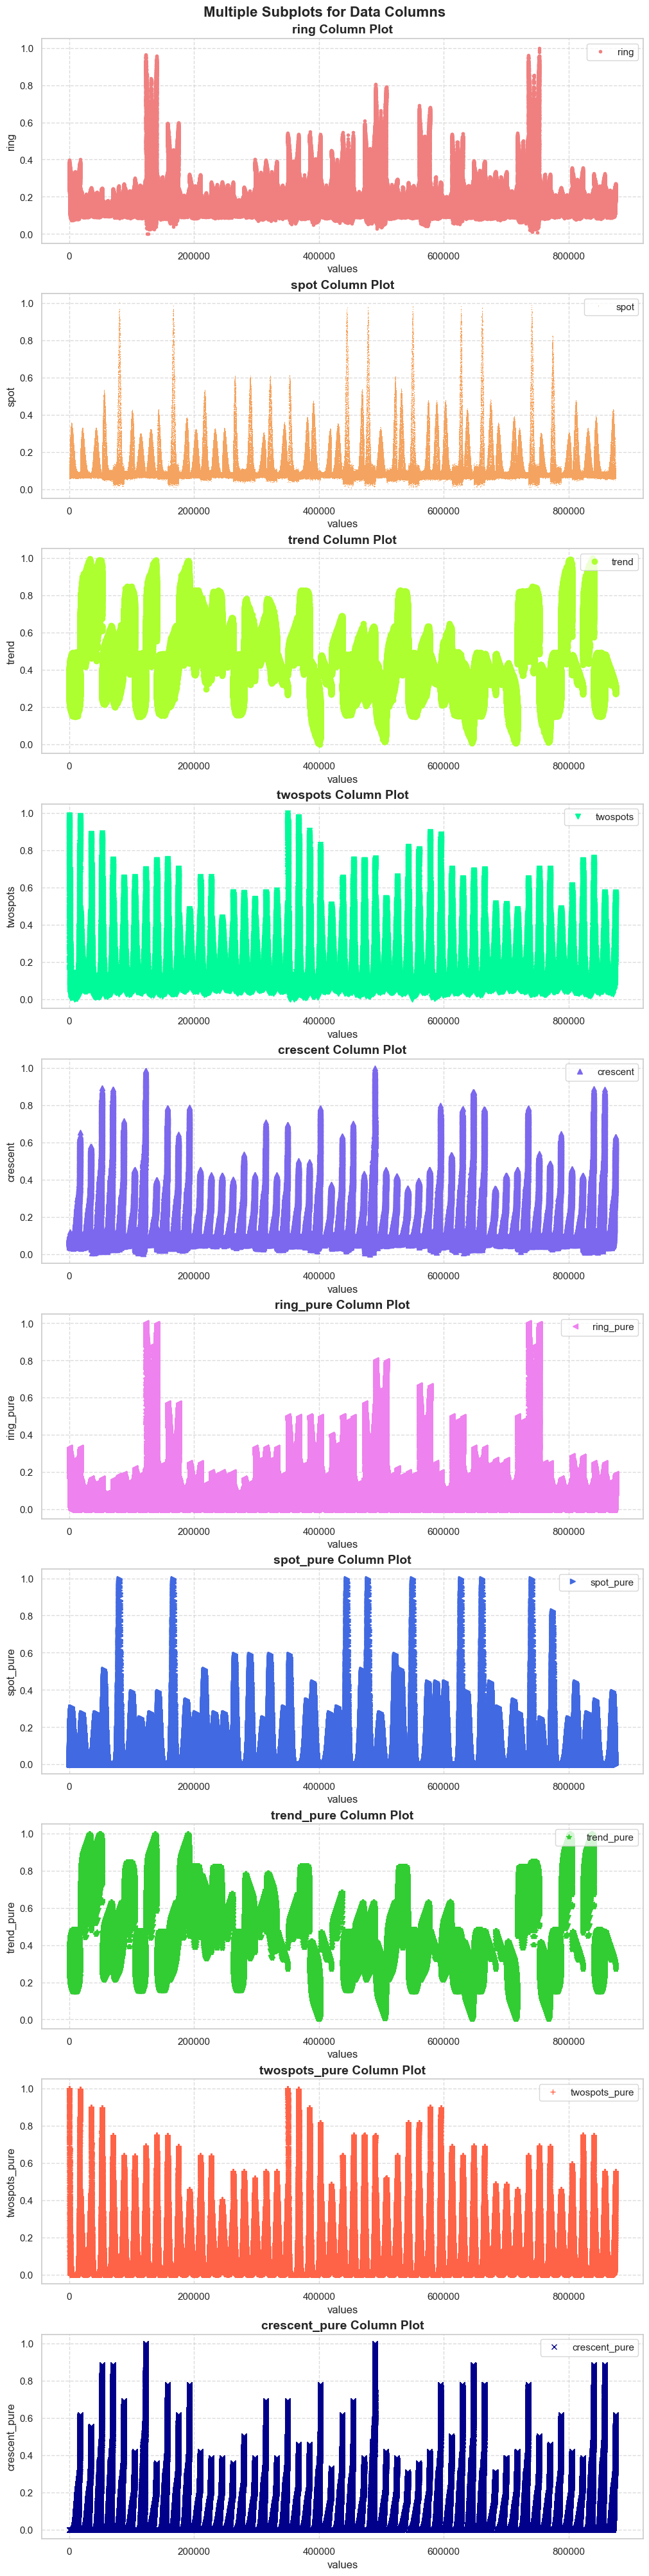

In [81]:
fig, axes = plt.subplots(nrows=len(data_col), ncols=1, figsize=(10, 40), constrained_layout=True)
colors = ['lightcoral', 'sandybrown', 'greenyellow', 'mediumspringgreen', 'mediumslateblue', 'violet', 'royalblue', 'limegreen', 'tomato', 'darkblue']
markers = ['.', ',', 'o', 'v', '^', '<', '>', '*', '+', 'x']
for i, col in enumerate(data_col):
    df[col].plot(ax=axes[i], title=f'{col} Data', grid=True, legend=True, marker=markers[i], linestyle='', color=colors[i])
    axes[i].set_xlabel('values')
    axes[i].set_ylabel(col)
    axes[i].legend([col], loc='upper right')
    axes[i].set_title(f'{col} Column Plot', fontsize=14, fontweight='bold')
    axes[i].grid(True, linestyle='--', alpha=0.7)

fig.suptitle('Multiple Subplots for Data Columns', fontsize=16, fontweight='bold')

#### Data matrix determinant 검증

In [82]:
data_col = ["ring", "spot", "trend", "twospots", "crescent", "ring_pure", "spot_pure", "trend_pure", "twospots_pure", "crescent_pure"]
pure_col = ["ring_pure", "spot_pure", "trend_pure", "twospots_pure", "crescent_pure"]
raw_col = ["ring", "spot", "trend", "twospots", "crescent"]

In [83]:
df_wf = df[df['wafer']==1]
d = df[data_col][:100]
np.linalg.det(d.T@d)

2.8836804840552407e-48

#### det == 0이므로 feature 상관관계 분석

In [84]:
corr_d = df[num_col].corr()

In [85]:
corr_d

,ring,spot,trend,twospots,crescent,ring_pure,spot_pure,trend_pure,twospots_pure,crescent_pure
ring,1.000000,-0.107395,-0.048691,0.395219,0.359287,0.994597,-0.108261,-0.048810,0.396557,0.360869
spot,-0.107395,1.000000,-0.004533,-0.107362,-0.092249,-0.107816,0.991885,-0.004528,-0.107592,-0.092530
trend,-0.048691,-0.004533,1.000000,-0.038215,-0.007401,-0.048869,-0.004584,0.998946,-0.038349,-0.007662
twospots,0.395219,-0.107362,-0.038215,1.000000,0.479316,0.397214,-0.108189,-0.038312,0.997036,0.481281
crescent,0.359287,-0.092249,-0.007401,0.479316,1.000000,0.361130,-0.092583,-0.007484,0.480775,0.995532
ring_pure,0.994597,-0.107816,-0.048869,0.397214,0.361130,1.000000,-0.108672,-0.048989,0.398550,0.362716
spot_pure,-0.108261,0.991885,-0.004584,-0.108189,-0.092583,-0.108672,1.000000,-0.004576,-0.108424,-0.092868
trend_pure,-0.048810,-0.004528,0.998946,-0.038312,-0.007484,-0.048989,-0.004576,1.000000,-0.038448,-0.007739
twospots_pure,0.396557,-0.107592,-0.038349,0.997036,0.480775,0.398550,-0.108424,-0.038448,1.000000,0.482748
crescent_pure,0.360869,-0.092530,-0.007662,0.481281,0.995532,0.362716,-0.092868,-0.007739,0.482748,1.000000


#### feature 간 correlation matrix 시각화

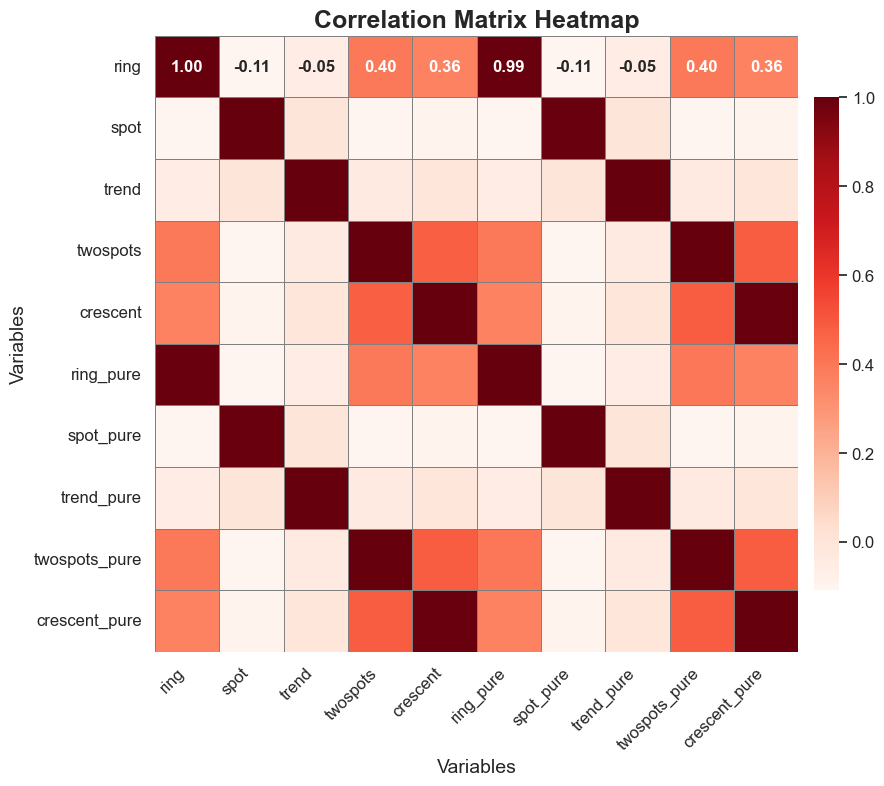

In [86]:
sns.set(style='white')

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(
    corr_d, annot=True, cmap='Reds', fmt='.2f', linewidths=.5, linecolor='gray',
    cbar_kws={'shrink': .8, 'aspect': 20, 'pad': 0.02, 'orientation': 'vertical'},
    annot_kws={'fontsize': 12, 'fontweight': 'bold'}
)

plt.title('Correlation Matrix Heatmap', fontsize=18, fontweight='bold')
plt.xlabel('Variables', fontsize=14)
plt.ylabel('Variables', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)

plt.show()

#### 일반 column과 _pure column 사이 강한 양의 상관관계 존재

C:\Users\User\AppData\Local\Temp\ipykernel_1536\3596928022.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatter = sns.scatterplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


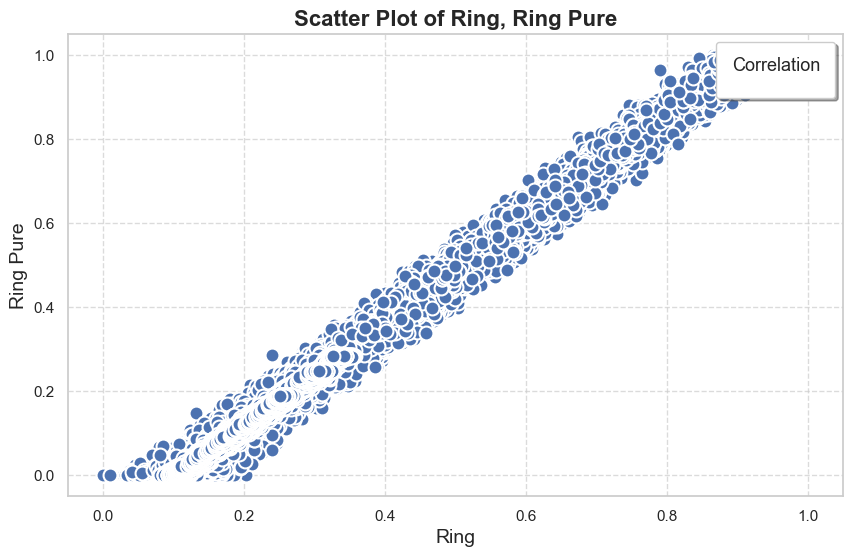

In [87]:
sns.set(style='whitegrid')

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=df, x='ring', y='ring_pure', palette='deep', s=100, markers=['o'],
    edgecolor='w', linewidth=1.5
)

scatter.set_title('Scatter Plot of Ring, Ring Pure', fontsize=16, fontweight='bold')
scatter.set_xlabel('Ring', fontsize=14)
scatter.set_ylabel('Ring Pure', fontsize=14)

plt.legend(title='Correlation', title_fontsize='13', fontsize='11', loc='upper right', markerscale=1.0, frameon=True, shadow=True, borderpad=1)
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

#### pure 데이터를 제외한 행렬의 det 확인 det!=0

In [88]:
d_raw = df[raw_col][:100]
np.linalg.det(d_raw.T@d_raw)

8.099038039504887e-06

### 8. 학습 feature 선택
#### drop pure data columns

In [89]:
df = df.drop(pure_col, axis='columns')

In [90]:
df

,lot,wafer,x,y,ring,spot,trend,twospots,crescent
0,Lot_1,1,1,67,0.376222,0.078889,0.329128,0.846450,0.079382
1,Lot_1,1,1,68,0.373062,0.071204,0.323302,0.876809,0.074144
2,Lot_1,1,1,69,0.377189,0.074456,0.316939,0.897562,0.070817
3,Lot_1,1,1,70,0.372155,0.070156,0.323954,0.881973,0.080196
4,Lot_1,1,1,71,0.368167,0.066347,0.315752,0.916017,0.081375
...,...,...,...,...,...,...,...,...,...
875445,Lot_1,50,115,100,0.262611,0.074384,0.285648,0.560981,0.509648
875446,Lot_1,50,115,101,0.256618,0.076624,0.281655,0.568618,0.492157
875447,Lot_1,50,115,102,0.260296,0.072305,0.282689,0.561163,0.487911
875448,Lot_1,50,115,103,0.258597,0.071035,0.277189,0.555043,0.506574


### 9. 전처리 데이터 csv 저장

In [93]:
pwd

'C:\\Users\\User\\project\\ai_intensive'

In [92]:
df.to_csv(root + '/dataset/training_set.csv', index=False)

In [ ]:
df = pd.read_csv(root + '/dataset/training_set.csv', encoding='cp949')

# 2) wafer map 생성 및 이미지 전처리
### &nbsp;&nbsp; 학습을 위해 각 wafer id별 map 이미지 생성 및 전처리


### 전처리 과정
    1. 각 wafer 별 x, y 매핑 이미지 데이터 생성
    2. map resize 및 학습 feature 벡터 생성

In [94]:
df_wf = df[df['wafer']==1]
df_wf

,lot,wafer,x,y,ring,spot,trend,twospots,crescent
0,Lot_1,1,1,67,0.376222,0.078889,0.329128,0.846450,0.079382
1,Lot_1,1,1,68,0.373062,0.071204,0.323302,0.876809,0.074144
2,Lot_1,1,1,69,0.377189,0.074456,0.316939,0.897562,0.070817
3,Lot_1,1,1,70,0.372155,0.070156,0.323954,0.881973,0.080196
4,Lot_1,1,1,71,0.368167,0.066347,0.315752,0.916017,0.081375
...,...,...,...,...,...,...,...,...,...
17504,Lot_1,1,115,100,0.375782,0.079891,0.282268,0.952696,0.509741
17505,Lot_1,1,115,101,0.379085,0.072865,0.300030,0.956471,0.509171
17506,Lot_1,1,115,102,0.371639,0.073579,0.292902,0.963568,0.515881
17507,Lot_1,1,115,103,0.374194,0.055087,0.294630,0.986381,0.506562


In [95]:
def scale_to_gray(data):
    min_val = np.min(data)
    max_val = np.max(data)
    scaled_data = 255 - (255 * (data - min_val) / (max_val - min_val))
    scaled_data_int = scaled_data.astype(np.uint8)
    return scaled_data_int

#### 120*200 wafer map을 numpy array로 생성
#### dataframe의 wafer id를 기준으로 x, y column 값을 순회하며 2차원 array data 생성

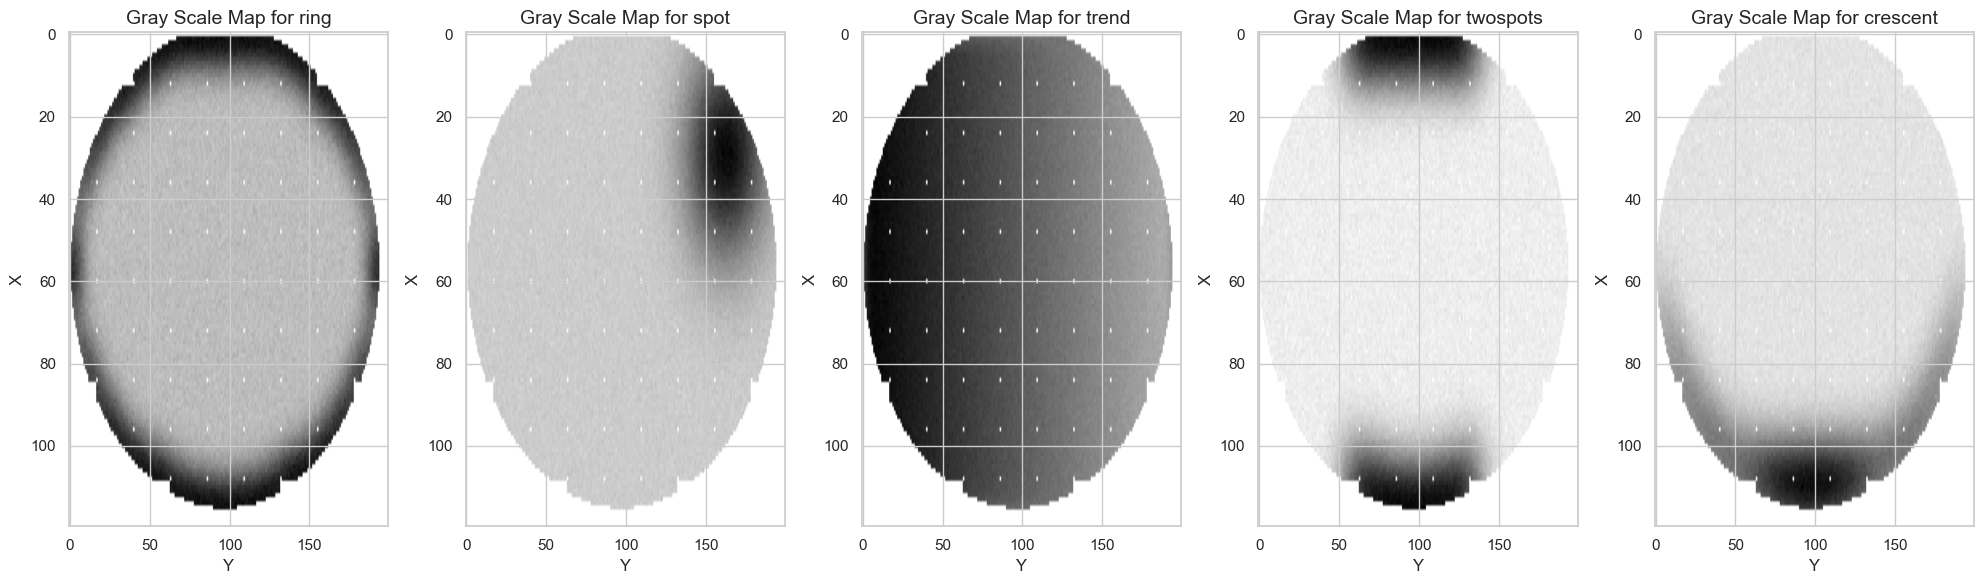

In [98]:
fig, axes = plt.subplots(nrows=1, ncols=len(raw_col), figsize=(20, 6))
for i, col in enumerate(raw_col):
    map = np.zeros([120, 200])
    for index, row in df_wf.iterrows():
        map[row['x']][row['y']] = row[col]
    gray_map = scale_to_gray(map)
    #plt.imshow(gray_map, cmap='gray', aspect='auto')
    #plt.savefig(f"image_{col}.png")

    axes[i].imshow(gray_map, cmap='gray', aspect='auto')
    axes[i].set_title(f'Gray Scale Map for {col}', fontsize=14)
    axes[i].set_xlabel('Y')
    axes[i].set_ylabel('X')

plt.tight_layout()
plt.show()

In [104]:
gray_map.shape

(120, 200)

In [107]:
import cv2
fig, axes = plt.subplots(nrows=1, ncols=len(raw_col), figsize=(20, 6))
for i, col in enumerate(raw_col):
    map = np.zeros([120, 200])
    for index, row in df_wf.iterrows():
        map[row['x']][row['y']] = row[col]
    gray_map = scale_to_gray(map)
    #plt.imshow(gray_map, cmap='gray', aspect='auto')
    #plt.savefig(f"image_{col}.png")
    resized_map = cv2.resize(gray_map, (30, 50))
    axes[i].imshow(resized_map, cmap='gray', aspect='auto')
    axes[i].set_title(f'Gray Scale Map for {col}', fontsize=14)
    axes[i].set_xlabel('Y')
    axes[i].set_ylabel('X')

plt.tight_layout()
plt.show()



ImportError: DLL load failed while importing cv2: 지정된 모듈을 찾을 수 없습니다.

#### 전체 training_set csv data map

In [44]:
df=pd.read_csv(root + f"/dataset/training_1.csv", encoding='cp949', sep=';')

In [45]:
df.head()

,lot,wafer,x,y,ring,spot,trend,twospots,crescent,ring_pure,spot_pure,trend_pure,twospots_pure,crescent_pure
0,Lot_1,1,1,67,"0,0332031730845769","6,48519201883132e-05","0,312294593060493","0,0390430665764935","0,00771987128577758","0,0325758284622229","6,54906689829159e-10","0,285687707722175","0,0395706499953045","-4,84314598172959e-17"
1,Lot_1,1,1,68,"0,0328173889580282","-4,66246954348572e-06","0,288024790081015","0,0405631417212302","0,00263633379698886","0,0327267641746118","8,76695244240241e-10","0,281496623060313","0,0404069156343969","-5,07606418493978e-17"
2,Lot_1,1,1,69,"0,0333211682053133","2,47580311665707e-05","0,261521426704379","0,0416022202035901","-0,000592417759195467","0,0328494417424522","1,16997736424868e-09","0,277305538398452","0,0411276544095511","-5,29028513056874e-17"
3,Lot_1,1,1,70,"0,0327066816529719","-1,41399015151066e-05","0,290740671081819","0,0408216721611609","0,00851014186519874","0,0329476626926438","1,55655995468072e-09","0,27311445373659","0,0417415065091455","-5,56129609519792e-17"
4,Lot_1,1,1,71,"0,0322198997669195","-4,85927969955997e-05","0,256578203050804","0,0425262452353082","0,00965410898796004","0,0330250576117472","2,06449498345691e-09","0,268923369074728","0,0422581887990589","-5,76665485366261e-17"


In [47]:
df = df[df["wafer"]<=50]

In [48]:
data_col = ["wafer", "x", "y", "ring", "spot", "trend", "twospots", "crescent"]
pure_col = ["ring_pure", "spot_pure", "trend_pure", "twospots_pure", "crescent_pure"]
raw_col = ["ring", "spot", "trend", "twospots", "crescent"]

In [49]:
df = df.drop(pure_col, axis='columns')

In [50]:
for idx in raw_col:
    df[idx] = df[idx].str.replace(',', '.')

In [51]:
df["x"].max() #115
df["y"].max() #193
df

,lot,wafer,x,y,ring,spot,trend,twospots,crescent
0,Lot_1,1,1,67,0.0332031730845769,6.48519201883132e-05,0.312294593060493,0.0390430665764935,0.00771987128577758
1,Lot_1,1,1,68,0.0328173889580282,-4.66246954348572e-06,0.288024790081015,0.0405631417212302,0.00263633379698886
2,Lot_1,1,1,69,0.0333211682053133,2.47580311665707e-05,0.261521426704379,0.0416022202035901,-0.000592417759195467
3,Lot_1,1,1,70,0.0327066816529719,-1.41399015151066e-05,0.290740671081819,0.0408216721611609,0.00851014186519874
4,Lot_1,1,1,71,0.0322198997669195,-4.85927969955997e-05,0.256578203050804,0.0425262452353082,0.00965410898796004
...,...,...,...,...,...,...,...,...,...
875445,Lot_1,50,115,100,0.0193355414687789,2.41059497948448e-05,0.131172439034415,0.0247499221046677,0.425302360876592
875446,Lot_1,50,115,101,0.0186041290225122,4.43642040896514e-05,0.114542563915356,0.0251322742058725,0.408327008366515
875447,Lot_1,50,115,102,0.0190530680695031,5.30042559998138e-06,0.118849765600642,0.0247590142812806,0.404205430437873
875448,Lot_1,50,115,103,0.0188456385343244,-6.18852259184481e-06,0.0959373203641775,0.0244525929724543,0.422318835408699


In [38]:
data = []
for wf_idx in range(1,201):
    df_wf = df_lot[df_lot['wafer']==wf_idx]
    for col in data_col:
        map = np.zeros([120, 200])
        for index, row in df_wf.iterrows():
            map[row['x']][row['y']] = row[col]
        gray_map = scale_to_gray(map)
        #plt.imshow(gray_map, cmap='gray', aspect='auto')
        #plt.savefig(f"image_{col}.png")
        data.append([map, col])

KeyboardInterrupt: 